In [1]:
import pandas as pd 
import numpy as np
import re
import torch 
import torch.nn as nn 
from torch.utils.data import TensorDataset,DataLoader
import matplotlib.pyplot as plt
import itertools
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
df_train = pd.read_csv('data/train.csv')

df_val = pd.read_csv('data/val.csv')

df_test = pd.read_csv('data/test.csv')

In [3]:
df_train.sample(10)

,text,label,check
45829,bọn đàn bà hầu hết coi đàn ông là osin của bọn...,0,NaN
11180,Múp ngon vào mà húp :)),0,NaN
5887,Nguyễn Thái An =)),0,NaN
16975,Mong là ưu tiên cho các nhà thầu trong nước th...,0,NaN
14657,Tiêm vacxin luôn đồng nghĩa với chấp nhận một ...,0,NaN
34465,Tuấn Nguyễn xem cách ly đi a,0,NaN
18975,nỗi nhục mất nước và thân phận làm nô lệ hình ...,1,True
31675,xe máy nườm nượp đi vào làn ô tô trên cầu chươ...,0,NaN
12126,Quang Nguyễn Đức lây chắc còn hơn cô Nhung 17 ...,0,NaN
27368,Bị mất chút đỉnh + bị xin tiền thôi chứ mất hế...,0,NaN


In [4]:
from gensim.models import KeyedVectors

path = 'word2vec_vi_words_300dims.txt'
modelw2v = KeyedVectors.load_word2vec_format(path, binary=False)

In [5]:
def standardize_data(row):
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    row = re.sub(r"[\.,\?]+$-", "", row)
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm than, ... trong câu
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")
    row = row.strip().lower()
    return row

In [6]:
df_train = df_train.drop(columns=['check'])
df_train['text'] = df_train['text'].apply(standardize_data)

df_val = df_val.drop(columns=['check'])
df_val['text'] = df_val['text'].apply(standardize_data)

df_test = df_test.drop(columns=['check'])
df_test['text'] = df_test['text'].apply(standardize_data)

In [7]:
def text_to_vector(text, modelw2v):
    words = text.split()  # Break the review into words
    word_vectors = []

    for word in words:
        if word in modelw2v:
            word_vectors.append(modelw2v[word])
    if len(word_vectors) > 0:
        # Averaging word vectors
        return np.mean(word_vectors, axis=0)

    else:
        # If the review does not have words in the model vocabulary
        return np.zeros(modelw2v.vector_size)

In [8]:
df_train['text'] = df_train['text'].apply(lambda x: text_to_vector(x, modelw2v))

df_val['text'] = df_val['text'].apply(lambda x: text_to_vector(x, modelw2v))

df_test['text'] = df_test['text'].apply(lambda x: text_to_vector(x, modelw2v))

In [9]:
text_tensors = torch.tensor(df_train['text'].tolist(), dtype=torch.float32)
label_tensors = torch.tensor(df_train['label'].values, dtype=torch.long)

# Tạo TensorDataset
train_data = TensorDataset(text_tensors, label_tensors)

C:\Users\ACER\AppData\Local\Temp\ipykernel_19540\37843088.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  text_tensors = torch.tensor(df_train['text'].tolist(), dtype=torch.float32)


In [10]:
text_tensors = torch.tensor(df_val['text'].tolist(), dtype=torch.float32)
label_tensors = torch.tensor(df_val['label'].values, dtype=torch.long)

# Tạo TensorDataset
val_data = TensorDataset(text_tensors, label_tensors)

In [11]:
text_tensors = torch.tensor(df_test['text'].tolist(), dtype=torch.float32)
label_tensors = torch.tensor(df_test['label'].values, dtype=torch.long)

# Tạo TensorDataset
test_data = TensorDataset(text_tensors, label_tensors)

# MODEL

In [12]:
batch_sizes = [32, 64]
learning_rates = [1e-3, 1e-4]
optimizers = ['Adam', 'SGD']
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(300, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
from torchsummary import summary

In [8]:
# summarize model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
summary(model, (300,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 300]               0
            Linear-2                  [-1, 512]         154,112
            Linear-3                  [-1, 256]         131,328
            Linear-4                    [-1, 2]             514
Total params: 285,954
Trainable params: 285,954
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.09
Estimated Total Size (MB): 1.10
----------------------------------------------------------------


In [14]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (output.argmax(1) == target).sum().item()
    return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Tính loss
            total_loss += criterion(output, target).item()
            
            # Lấy nhãn dự đoán
            preds = output.argmax(1)
            
            # Đếm số dự đoán đúng
            correct += (preds == target).sum().item()
            
            # Lưu nhãn thực tế và nhãn dự đoán
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    return avg_loss, accuracy, true_labels, predicted_labels

Training MLP with batch_size=32, lr=0.001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0121, Train Acc: 0.8379, Val Loss: 0.0118, Val Acc: 0.8548
Epoch 2/10 -> Train Loss: 0.0110, Train Acc: 0.8535, Val Loss: 0.0106, Val Acc: 0.8628
Epoch 3/10 -> Train Loss: 0.0105, Train Acc: 0.8601, Val Loss: 0.0106, Val Acc: 0.8612
Epoch 4/10 -> Train Loss: 0.0103, Train Acc: 0.8651, Val Loss: 0.0110, Val Acc: 0.8623
Epoch 5/10 -> Train Loss: 0.0100, Train Acc: 0.8675, Val Loss: 0.0100, Val Acc: 0.8749
Epoch 6/10 -> Train Loss: 0.0098, Train Acc: 0.8722, Val Loss: 0.0101, Val Acc: 0.8711
Epoch 7/10 -> Train Loss: 0.0095, Train Acc: 0.8754, Val Loss: 0.0099, Val Acc: 0.8742
Epoch 8/10 -> Train Loss: 0.0093, Train Acc: 0.8793, Val Loss: 0.0103, Val Acc: 0.8667
Epoch 9/10 -> Train Loss: 0.0091, Train Acc: 0.8811, Val Loss: 0.0100, Val Acc: 0.8742
Epoch 10/10 -> Train Loss: 0.0089, Train Acc: 0.8832, Val Loss: 0.0102, Val Acc: 0.8729
Final Results (Batch=32, LR=0.001, Opt=Adam):
Precision: 0.8521, Recall

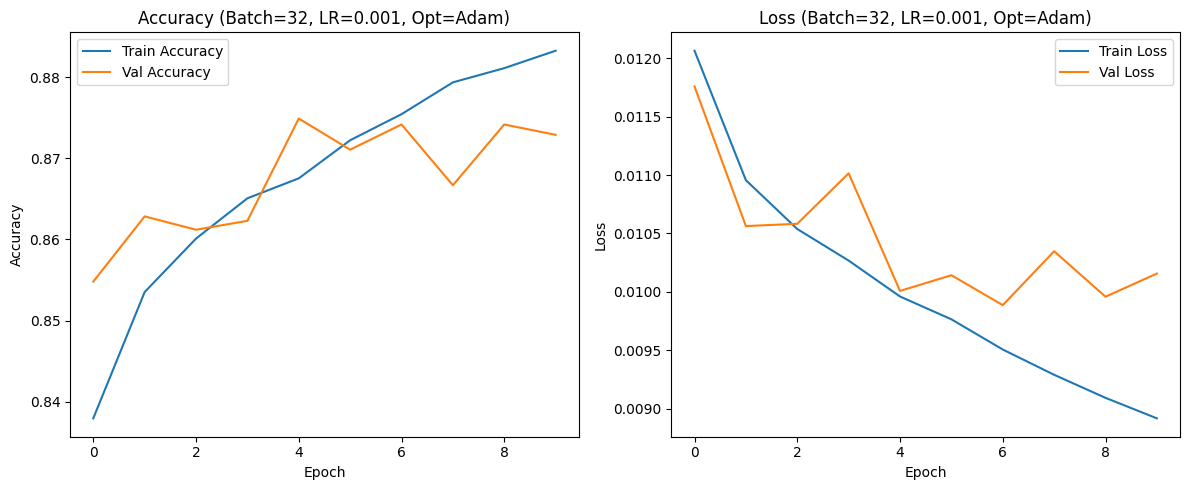

Training MLP with batch_size=32, lr=0.001, optimizer=SGD
Epoch 1/10 -> Train Loss: 0.0179, Train Acc: 0.8158, Val Loss: 0.0155, Val Acc: 0.8365
Epoch 2/10 -> Train Loss: 0.0154, Train Acc: 0.8158, Val Loss: 0.0144, Val Acc: 0.8365
Epoch 3/10 -> Train Loss: 0.0150, Train Acc: 0.8158, Val Loss: 0.0141, Val Acc: 0.8365
Epoch 4/10 -> Train Loss: 0.0149, Train Acc: 0.8158, Val Loss: 0.0140, Val Acc: 0.8365
Epoch 5/10 -> Train Loss: 0.0149, Train Acc: 0.8158, Val Loss: 0.0140, Val Acc: 0.8365
Epoch 6/10 -> Train Loss: 0.0149, Train Acc: 0.8158, Val Loss: 0.0140, Val Acc: 0.8365
Epoch 7/10 -> Train Loss: 0.0149, Train Acc: 0.8158, Val Loss: 0.0140, Val Acc: 0.8365
Epoch 8/10 -> Train Loss: 0.0149, Train Acc: 0.8158, Val Loss: 0.0140, Val Acc: 0.8365
Epoch 9/10 -> Train Loss: 0.0149, Train Acc: 0.8158, Val Loss: 0.0140, Val Acc: 0.8365
Epoch 10/10 -> Train Loss: 0.0149, Train Acc: 0.8158, Val Loss: 0.0140, Val Acc: 0.8365
Final Results (Batch=32, LR=0.001, Opt=SGD):
Precision: 0.6998, Recall: 

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


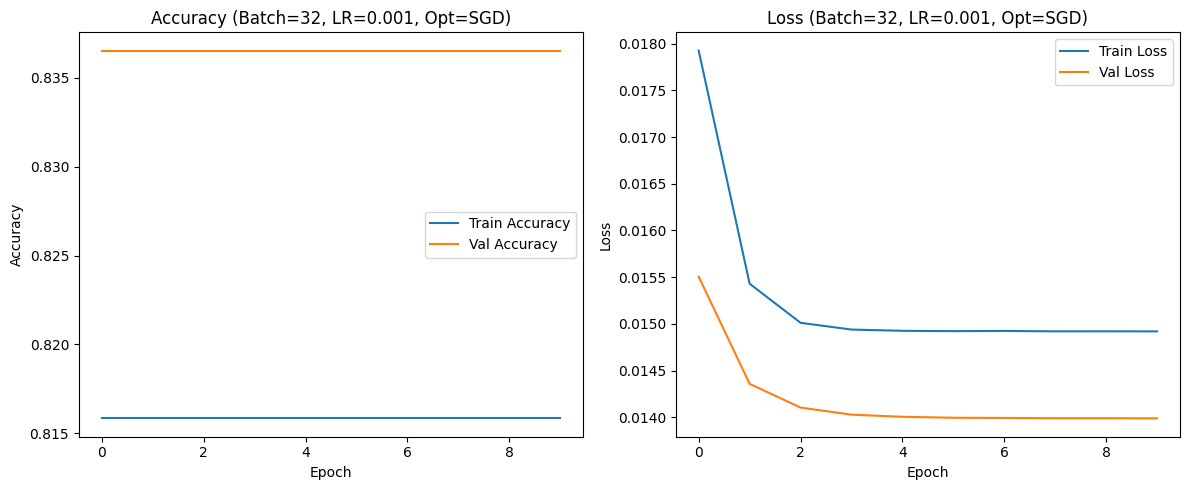

Training MLP with batch_size=32, lr=0.0001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0135, Train Acc: 0.8229, Val Loss: 0.0112, Val Acc: 0.8535
Epoch 2/10 -> Train Loss: 0.0113, Train Acc: 0.8475, Val Loss: 0.0106, Val Acc: 0.8625
Epoch 3/10 -> Train Loss: 0.0108, Train Acc: 0.8552, Val Loss: 0.0103, Val Acc: 0.8668
Epoch 4/10 -> Train Loss: 0.0104, Train Acc: 0.8609, Val Loss: 0.0102, Val Acc: 0.8705
Epoch 5/10 -> Train Loss: 0.0102, Train Acc: 0.8656, Val Loss: 0.0101, Val Acc: 0.8712
Epoch 6/10 -> Train Loss: 0.0100, Train Acc: 0.8689, Val Loss: 0.0100, Val Acc: 0.8712
Epoch 7/10 -> Train Loss: 0.0098, Train Acc: 0.8708, Val Loss: 0.0099, Val Acc: 0.8756
Epoch 8/10 -> Train Loss: 0.0097, Train Acc: 0.8722, Val Loss: 0.0098, Val Acc: 0.8787
Epoch 9/10 -> Train Loss: 0.0095, Train Acc: 0.8763, Val Loss: 0.0099, Val Acc: 0.8729
Epoch 10/10 -> Train Loss: 0.0094, Train Acc: 0.8773, Val Loss: 0.0100, Val Acc: 0.8753
Final Results (Batch=32, LR=0.0001, Opt=Adam):
Precision: 0.8555, Reca

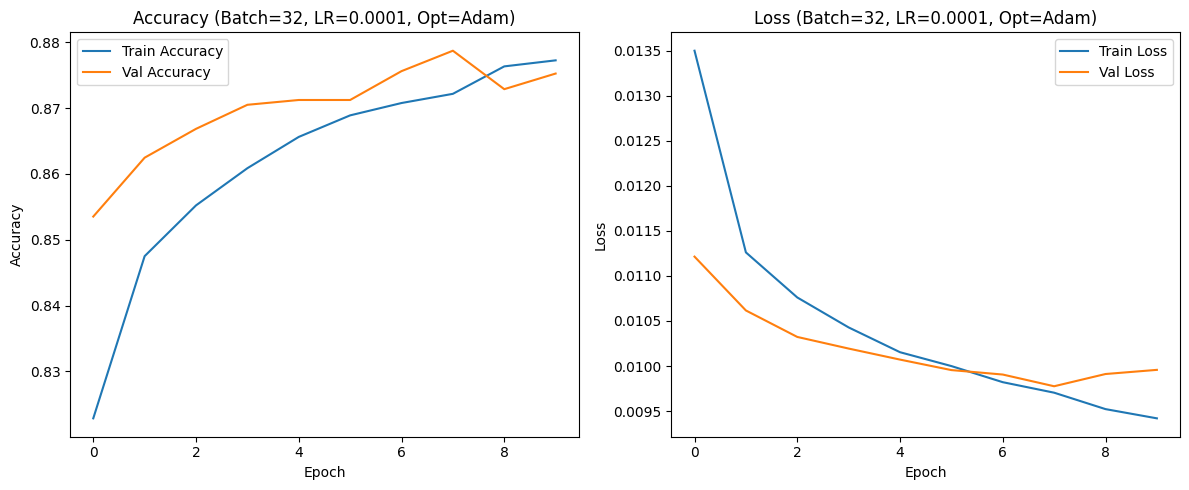

Training MLP with batch_size=32, lr=0.0001, optimizer=SGD
Epoch 1/10 -> Train Loss: 0.0208, Train Acc: 0.8158, Val Loss: 0.0202, Val Acc: 0.8365
Epoch 2/10 -> Train Loss: 0.0198, Train Acc: 0.8158, Val Loss: 0.0192, Val Acc: 0.8365
Epoch 3/10 -> Train Loss: 0.0189, Train Acc: 0.8158, Val Loss: 0.0184, Val Acc: 0.8365
Epoch 4/10 -> Train Loss: 0.0182, Train Acc: 0.8158, Val Loss: 0.0177, Val Acc: 0.8365
Epoch 5/10 -> Train Loss: 0.0177, Train Acc: 0.8158, Val Loss: 0.0172, Val Acc: 0.8365
Epoch 6/10 -> Train Loss: 0.0172, Train Acc: 0.8158, Val Loss: 0.0167, Val Acc: 0.8365
Epoch 7/10 -> Train Loss: 0.0168, Train Acc: 0.8158, Val Loss: 0.0163, Val Acc: 0.8365
Epoch 8/10 -> Train Loss: 0.0165, Train Acc: 0.8158, Val Loss: 0.0159, Val Acc: 0.8365
Epoch 9/10 -> Train Loss: 0.0162, Train Acc: 0.8158, Val Loss: 0.0156, Val Acc: 0.8365
Epoch 10/10 -> Train Loss: 0.0160, Train Acc: 0.8158, Val Loss: 0.0154, Val Acc: 0.8365
Final Results (Batch=32, LR=0.0001, Opt=SGD):
Precision: 0.6998, Recall

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


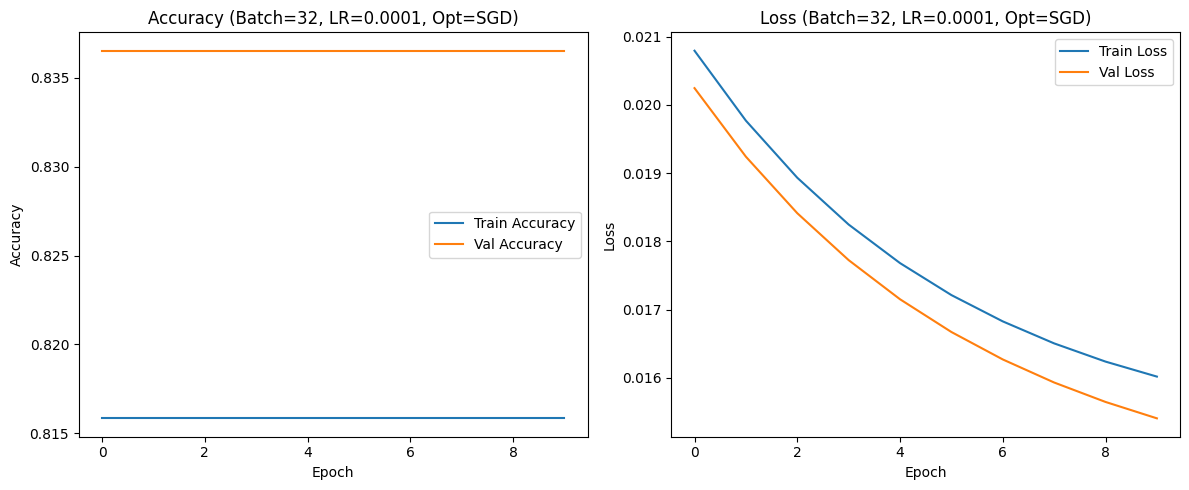

Training MLP with batch_size=64, lr=0.001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0061, Train Acc: 0.8350, Val Loss: 0.0055, Val Acc: 0.8561
Epoch 2/10 -> Train Loss: 0.0054, Train Acc: 0.8542, Val Loss: 0.0051, Val Acc: 0.8672
Epoch 3/10 -> Train Loss: 0.0053, Train Acc: 0.8589, Val Loss: 0.0050, Val Acc: 0.8709
Epoch 4/10 -> Train Loss: 0.0051, Train Acc: 0.8670, Val Loss: 0.0050, Val Acc: 0.8740
Epoch 5/10 -> Train Loss: 0.0050, Train Acc: 0.8700, Val Loss: 0.0052, Val Acc: 0.8670
Epoch 6/10 -> Train Loss: 0.0049, Train Acc: 0.8720, Val Loss: 0.0050, Val Acc: 0.8763
Epoch 7/10 -> Train Loss: 0.0048, Train Acc: 0.8745, Val Loss: 0.0050, Val Acc: 0.8731
Epoch 8/10 -> Train Loss: 0.0047, Train Acc: 0.8785, Val Loss: 0.0053, Val Acc: 0.8725
Epoch 9/10 -> Train Loss: 0.0046, Train Acc: 0.8807, Val Loss: 0.0050, Val Acc: 0.8731
Epoch 10/10 -> Train Loss: 0.0045, Train Acc: 0.8840, Val Loss: 0.0051, Val Acc: 0.8714
Final Results (Batch=64, LR=0.001, Opt=Adam):
Precision: 0.8556, Recall

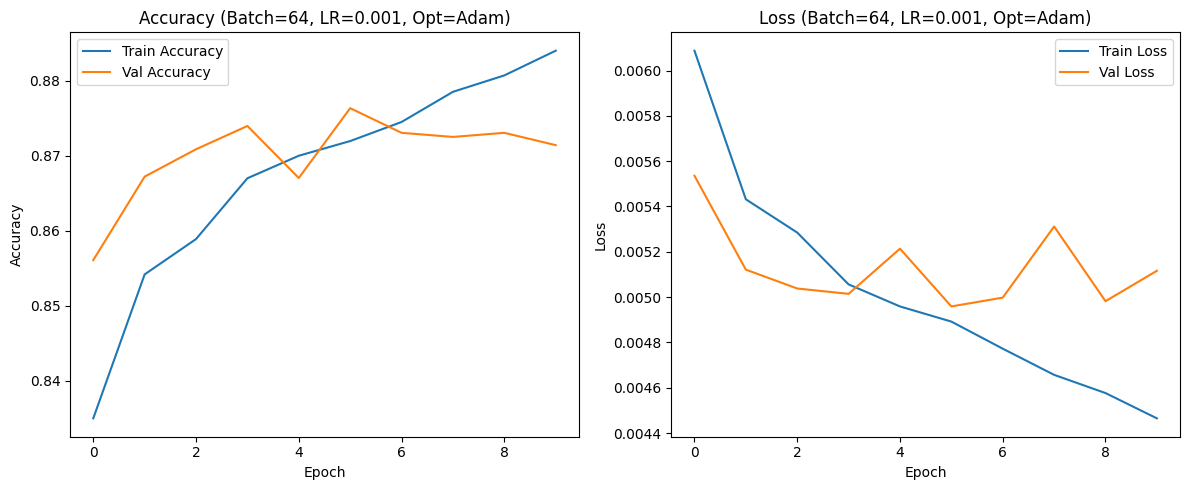

Training MLP with batch_size=64, lr=0.001, optimizer=SGD
Epoch 1/10 -> Train Loss: 0.0095, Train Acc: 0.8158, Val Loss: 0.0086, Val Acc: 0.8365
Epoch 2/10 -> Train Loss: 0.0083, Train Acc: 0.8158, Val Loss: 0.0077, Val Acc: 0.8365
Epoch 3/10 -> Train Loss: 0.0078, Train Acc: 0.8158, Val Loss: 0.0074, Val Acc: 0.8365
Epoch 4/10 -> Train Loss: 0.0076, Train Acc: 0.8158, Val Loss: 0.0072, Val Acc: 0.8365
Epoch 5/10 -> Train Loss: 0.0075, Train Acc: 0.8158, Val Loss: 0.0071, Val Acc: 0.8365
Epoch 6/10 -> Train Loss: 0.0075, Train Acc: 0.8158, Val Loss: 0.0071, Val Acc: 0.8365
Epoch 7/10 -> Train Loss: 0.0075, Train Acc: 0.8158, Val Loss: 0.0070, Val Acc: 0.8365
Epoch 8/10 -> Train Loss: 0.0075, Train Acc: 0.8158, Val Loss: 0.0070, Val Acc: 0.8365
Epoch 9/10 -> Train Loss: 0.0075, Train Acc: 0.8158, Val Loss: 0.0070, Val Acc: 0.8365
Epoch 10/10 -> Train Loss: 0.0075, Train Acc: 0.8158, Val Loss: 0.0070, Val Acc: 0.8365
Final Results (Batch=64, LR=0.001, Opt=SGD):
Precision: 0.6998, Recall: 

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


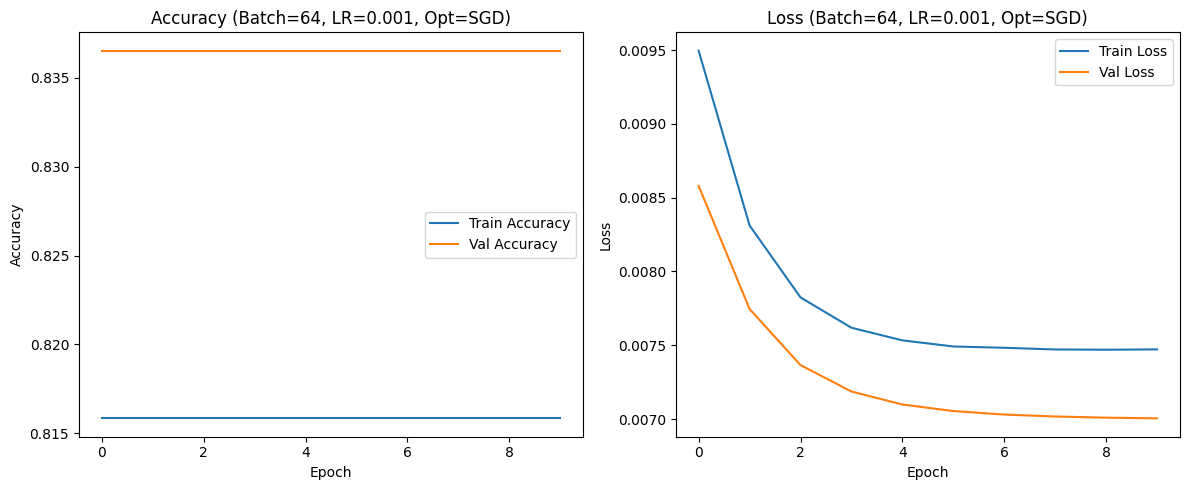

Training MLP with batch_size=64, lr=0.0001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0073, Train Acc: 0.8085, Val Loss: 0.0059, Val Acc: 0.8418
Epoch 2/10 -> Train Loss: 0.0058, Train Acc: 0.8405, Val Loss: 0.0054, Val Acc: 0.8623
Epoch 3/10 -> Train Loss: 0.0055, Train Acc: 0.8518, Val Loss: 0.0053, Val Acc: 0.8634
Epoch 4/10 -> Train Loss: 0.0053, Train Acc: 0.8567, Val Loss: 0.0052, Val Acc: 0.8676
Epoch 5/10 -> Train Loss: 0.0052, Train Acc: 0.8616, Val Loss: 0.0051, Val Acc: 0.8683
Epoch 6/10 -> Train Loss: 0.0051, Train Acc: 0.8648, Val Loss: 0.0051, Val Acc: 0.8709
Epoch 7/10 -> Train Loss: 0.0050, Train Acc: 0.8677, Val Loss: 0.0056, Val Acc: 0.8619
Epoch 8/10 -> Train Loss: 0.0049, Train Acc: 0.8707, Val Loss: 0.0051, Val Acc: 0.8725
Epoch 9/10 -> Train Loss: 0.0049, Train Acc: 0.8730, Val Loss: 0.0051, Val Acc: 0.8721
Epoch 10/10 -> Train Loss: 0.0048, Train Acc: 0.8752, Val Loss: 0.0050, Val Acc: 0.8736
Final Results (Batch=64, LR=0.0001, Opt=Adam):
Precision: 0.8528, Reca

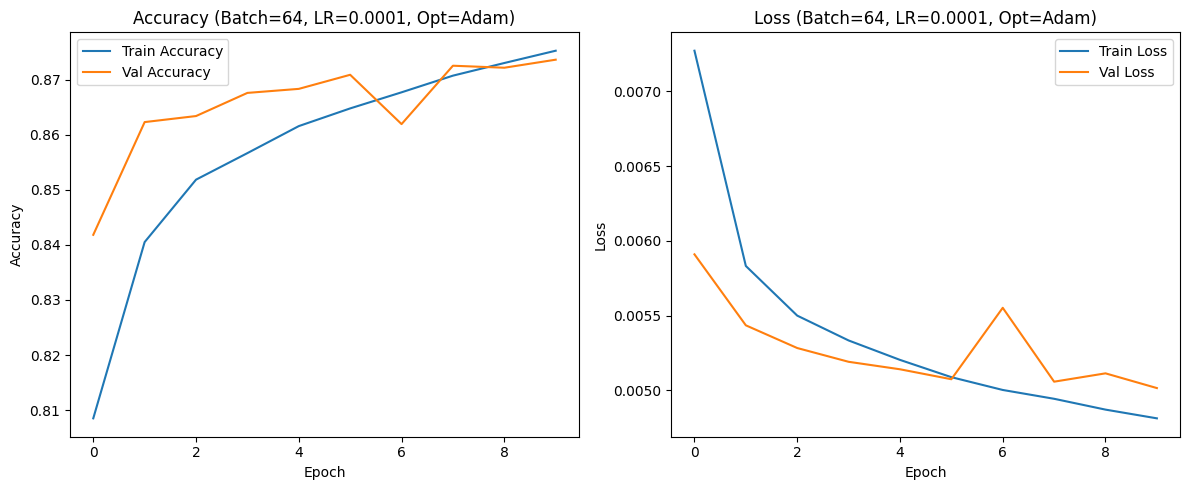

Training MLP with batch_size=64, lr=0.0001, optimizer=SGD
Epoch 1/10 -> Train Loss: 0.0106, Train Acc: 0.8158, Val Loss: 0.0105, Val Acc: 0.8365
Epoch 2/10 -> Train Loss: 0.0103, Train Acc: 0.8158, Val Loss: 0.0102, Val Acc: 0.8365
Epoch 3/10 -> Train Loss: 0.0101, Train Acc: 0.8158, Val Loss: 0.0099, Val Acc: 0.8365
Epoch 4/10 -> Train Loss: 0.0098, Train Acc: 0.8158, Val Loss: 0.0097, Val Acc: 0.8365
Epoch 5/10 -> Train Loss: 0.0096, Train Acc: 0.8158, Val Loss: 0.0095, Val Acc: 0.8365
Epoch 6/10 -> Train Loss: 0.0094, Train Acc: 0.8158, Val Loss: 0.0093, Val Acc: 0.8365
Epoch 7/10 -> Train Loss: 0.0093, Train Acc: 0.8158, Val Loss: 0.0091, Val Acc: 0.8365
Epoch 8/10 -> Train Loss: 0.0091, Train Acc: 0.8158, Val Loss: 0.0089, Val Acc: 0.8365
Epoch 9/10 -> Train Loss: 0.0090, Train Acc: 0.8158, Val Loss: 0.0088, Val Acc: 0.8365
Epoch 10/10 -> Train Loss: 0.0088, Train Acc: 0.8158, Val Loss: 0.0086, Val Acc: 0.8365
Final Results (Batch=64, LR=0.0001, Opt=SGD):
Precision: 0.6998, Recall

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


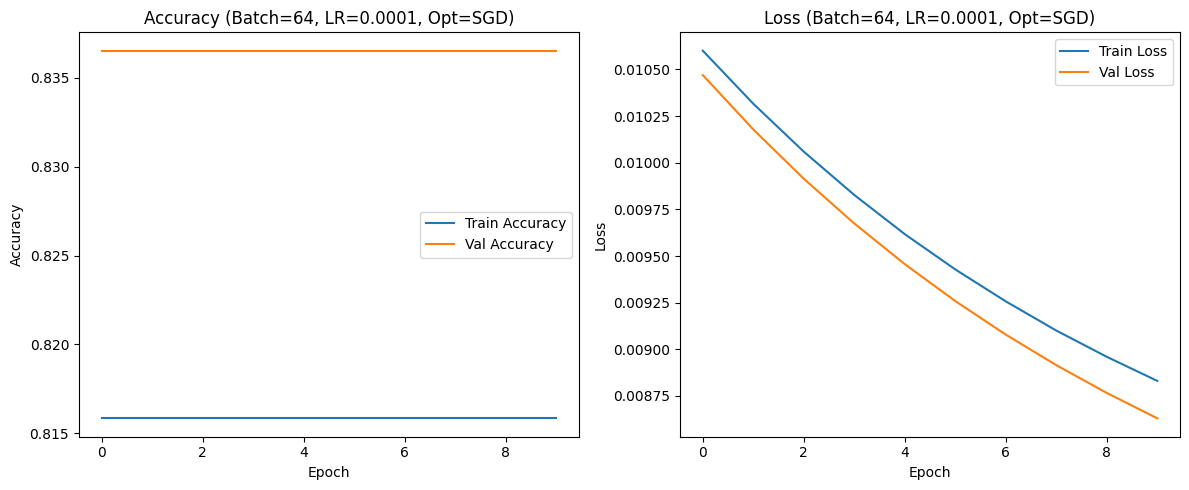

In [15]:
for batch_size, learning_rate, optimizer_name in itertools.product(batch_sizes, learning_rates, optimizers):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    model = MLP().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    print(f"Training MLP with batch_size={batch_size}, lr={learning_rate}, optimizer={optimizer_name}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    all_true_labels, all_predicted_labels = [], []

    for epoch in range(10):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, true_labels, predicted_labels = evaluate(model, val_loader, criterion, device)
        
        
        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/10 -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Tính Precision, Recall, F1-Score sau khi hoàn tất các epoch
    precision = precision_score(all_true_labels, all_predicted_labels, average="weighted")
    recall = recall_score(all_true_labels, all_predicted_labels, average="weighted")
    f1 = f1_score(all_true_labels, all_predicted_labels, average="weighted")

    print(f"Final Results (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name}):")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    torch.save(model.state_dict(), f"model_batch_{batch_size}_lr_{learning_rate}_optimizer_{optimizer_name}.pth")
    # Store results
    results.append((batch_size, learning_rate, optimizer_name, max(val_accs)))

    # Plot accuracy and loss for each combination
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Val Accuracy")
    plt.title(f"Accuracy (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title(f"Loss (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Chọn Batch = 32, Optim = Adam, Learning_rate = 0.0001

In [16]:
batch_sizes = [32]
learning_rates = [1e-4]
optimizers = ['Adam']
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training MLP with batch_size=32, lr=0.0001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0137, Train Acc: 0.8186, Test Loss: 0.0108, Test Acc: 0.8664
Epoch 2/10 -> Train Loss: 0.0113, Train Acc: 0.8461, Test Loss: 0.0098, Test Acc: 0.8791
Epoch 3/10 -> Train Loss: 0.0108, Train Acc: 0.8563, Test Loss: 0.0096, Test Acc: 0.8775
Epoch 4/10 -> Train Loss: 0.0104, Train Acc: 0.8619, Test Loss: 0.0093, Test Acc: 0.8837
Epoch 5/10 -> Train Loss: 0.0102, Train Acc: 0.8652, Test Loss: 0.0095, Test Acc: 0.8787
Epoch 6/10 -> Train Loss: 0.0100, Train Acc: 0.8669, Test Loss: 0.0091, Test Acc: 0.8868
Epoch 7/10 -> Train Loss: 0.0098, Train Acc: 0.8715, Test Loss: 0.0090, Test Acc: 0.8896
Epoch 8/10 -> Train Loss: 0.0097, Train Acc: 0.8736, Test Loss: 0.0091, Test Acc: 0.8838
Epoch 9/10 -> Train Loss: 0.0096, Train Acc: 0.8756, Test Loss: 0.0091, Test Acc: 0.8827
Epoch 10/10 -> Train Loss: 0.0094, Train Acc: 0.8777, Test Loss: 0.0088, Test Acc: 0.8885
Final Results (Batch=32, LR=0.0001, Opt=Adam):
Pre

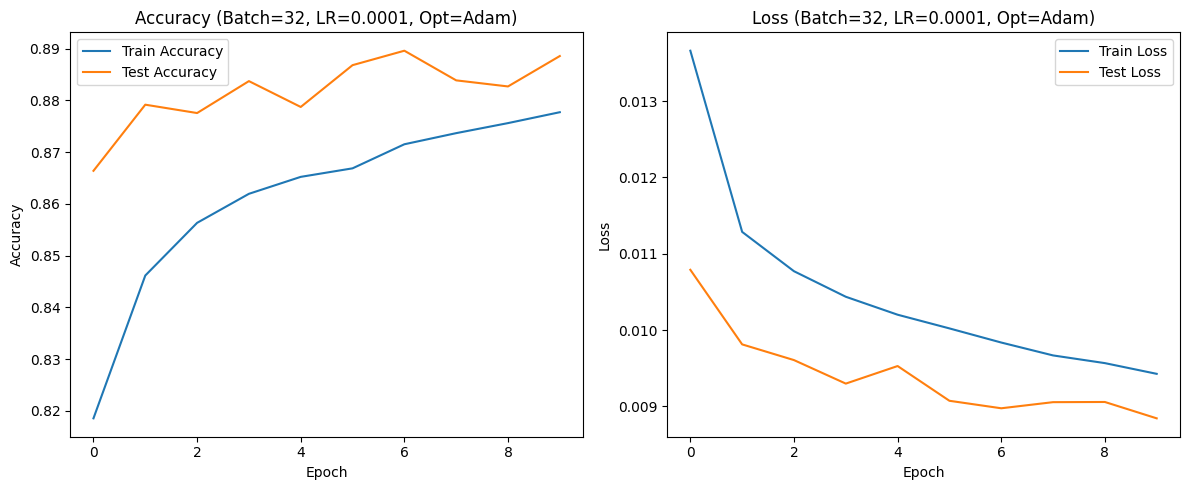

In [17]:
for batch_size, learning_rate, optimizer_name in itertools.product(batch_sizes, learning_rates, optimizers):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

        model = MLP().to(device)
        criterion = nn.CrossEntropyLoss()

        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        print(f"Training MLP with batch_size={batch_size}, lr={learning_rate}, optimizer={optimizer_name}")

        train_losses, test_losses = [], []
        train_accs, test_accs = [], []
        all_true_labels, all_predicted_labels = [], []

        for epoch in range(10):
            train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc, true_labels, predicted_labels = evaluate(model, test_loader, criterion, device)
        
            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            test_accs.append(test_acc)

            print(f"Epoch {epoch+1}/10 -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        precision = precision_score(all_true_labels, all_predicted_labels, average="weighted")
        recall = recall_score(all_true_labels, all_predicted_labels, average="weighted")
        f1 = f1_score(all_true_labels, all_predicted_labels, average="weighted")

        print(f"Final Results (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name}):")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
            
        torch.save(model.state_dict(), "MLPmodel.pth")
        # Store results
        results.append((batch_size, learning_rate, optimizer_name, max(test_accs)))

        # Plot accuracy and loss for each combination
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_accs, label="Train Accuracy")
        plt.plot(test_accs, label="Test Accuracy")
        plt.title(f"Accuracy (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_losses, label="Train Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.title(f"Loss (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.show()

        

In [18]:
# Khởi tạo mô hình mới và tải trọng số đã lưu
model = MLP().to(device)
model.load_state_dict(torch.load("MLPmodel.pth"))
model.eval()  


input = text_to_vector('thằng quân ngu quá',modelw2v)
input = torch.tensor(input).float()
input = input.unsqueeze(0)
outputs = model(input)  
_, predicted = torch.max(outputs, 1)  # Lấy lớp có xác suất cao nhất

print(predicted.item())

1
